In [2]:
import gzip
import pickle
import numpy as np
from pathlib import Path
import torch
from  acr_bb import Observation, ACRBBenv, DefaultBranchingPolicy, RandomPolicy, LinearObservation
from fcn_training import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy 

MAX_SAMPLES = 10000

N = 8 # antennas
M = 4 # users
expert_prob = 0.5

def instance_generator(M, N):
    while 1:
        yield np.random.randn(2,N,M)

# instances = np.random.randn(MAX_SAMPLES, 2, N, M)
instances = instance_generator(M,N)

env = ACRBBenv(observation_function=LinearObservation)

expert_policy = DefaultBranchingPolicy()
random_policy = RandomPolicy()

In [3]:
episode_counter, sample_counter = 0, 0
Path('fcn_samples/').mkdir(exist_ok=True)

# We will solve problems (run episodes) until we have saved enough samples
max_samples_reached = False
while not max_samples_reached:
    episode_counter += 1
    
    observation, action_set, _, done, _ = env.reset(next(instances))
    while not done:
        if np.random.rand(1) > expert_prob:
            action_id = expert_policy.select_variable(observation, action_set)
            expert = True
        else:
            action_id = random_policy.select_variable(observation, action_set)
            expert = False
            
        # Only save samples if they are coming from the expert (strong branching)
        if expert and not max_samples_reached:
            sample_counter += 1
            data = [observation, action_id, action_set]
            filename = f'fcn_samples/sample_{sample_counter}.pkl'

            with gzip.open(filename, 'wb') as f:
                pickle.dump(data, f)
            
            # If we collected enough samples, we finish the current episode but stop saving samples
            if sample_counter == MAX_SAMPLES:
                max_samples_reached = True

        observation, action_set, _, done, _ = env.step(action_id)

        
    print(f"Episode {episode_counter}, {sample_counter} samples collected so far")


Episode 1, 140 samples collected so far
Episode 2, 443 samples collected so far
Episode 3, 738 samples collected so far
Episode 4, 891 samples collected so far
Episode 5, 1102 samples collected so far
Episode 6, 1506 samples collected so far
Episode 7, 1708 samples collected so far
Episode 8, 1742 samples collected so far
Episode 9, 1993 samples collected so far
Episode 10, 2304 samples collected so far
Episode 11, 2405 samples collected so far
Episode 12, 2536 samples collected so far
Episode 13, 2642 samples collected so far
Episode 14, 2720 samples collected so far
Episode 15, 2854 samples collected so far
Episode 16, 3003 samples collected so far
Episode 17, 3516 samples collected so far
Episode 18, 3575 samples collected so far
Episode 19, 3713 samples collected so far
Episode 20, 3972 samples collected so far
Episode 21, 4152 samples collected so far
[0.         4.71238898 5.69413668 3.53429174] [6.28318531 4.90873852 5.89048623 3.92699082]
Episode 22, 4311 samples collected so f

In [4]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from pathlib import Path
from fcn_training import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy
from torch.utils.data import DataLoader


LEARNING_RATE = 0.001
NB_EPOCHS = 50
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    with torch.set_grad_enabled(optimizer is not None):
        for batch in tqdm(data_loader):
            obs, target = batch
            obs = obs.to(DEVICE)
            target = target.to(DEVICE)
            target = target - 1
            logits = policy(obs)
            candidates = torch.LongTensor([1,2,3])
#             candidates = candidates.repeat(len(obs), 1)
            logits = logits[:,candidates]
            
            # Compute the usual cross-entropy classification loss
            loss = F.cross_entropy(logits, target)
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            predicted_bestindex = logits.max(dim=-1, keepdims=True).indices
            accuracy = sum(predicted_bestindex.reshape(-1) == target)
#             accuracy = (true_scores.gather(-1, predicted_bestindex) == true_bestscore).float().mean().item()

            mean_loss += loss.item()*len(obs)
            mean_acc += float(accuracy)
            n_samples_processed += len(obs)

    mean_loss /= n_samples_processed
    mean_acc /= n_samples_processed
    return mean_loss, mean_acc


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output


sample_files = [str(path) for path in Path('fcn_samples/').glob('sample_*.pkl')]
train_files = sample_files[:int(0.8*len(sample_files))]
valid_files = sample_files[int(0.8*len(sample_files)):]

train_data = FCNDataset(train_files)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_data = FCNDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

policy = FCNBranchingPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss, train_acc = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss:0.3f}, accuracy {train_acc:0.3f}" )

    valid_loss, valid_acc = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
    valids.append(valid_acc)

torch.save(policy.state_dict(), 'trained_params.pkl')

Epoch 1


100%|██████████| 250/250 [00:01<00:00, 164.80it/s]


Train loss: 0.755, accuracy 0.665


100%|██████████| 63/63 [00:00<00:00, 268.63it/s]


Valid loss: 0.700, accuracy 0.685
Epoch 2


100%|██████████| 250/250 [00:01<00:00, 171.78it/s]


Train loss: 0.599, accuracy 0.717


100%|██████████| 63/63 [00:00<00:00, 279.27it/s]


Valid loss: 0.697, accuracy 0.700
Epoch 3


100%|██████████| 250/250 [00:01<00:00, 171.46it/s]


Train loss: 0.570, accuracy 0.729


100%|██████████| 63/63 [00:00<00:00, 278.55it/s]


Valid loss: 0.692, accuracy 0.682
Epoch 4


100%|██████████| 250/250 [00:01<00:00, 170.44it/s]


Train loss: 0.555, accuracy 0.730


100%|██████████| 63/63 [00:00<00:00, 282.28it/s]


Valid loss: 0.660, accuracy 0.705
Epoch 5


100%|██████████| 250/250 [00:01<00:00, 173.21it/s]


Train loss: 0.543, accuracy 0.738


100%|██████████| 63/63 [00:00<00:00, 280.85it/s]


Valid loss: 0.678, accuracy 0.713
Epoch 6


100%|██████████| 250/250 [00:01<00:00, 173.08it/s]


Train loss: 0.526, accuracy 0.747


100%|██████████| 63/63 [00:00<00:00, 279.87it/s]


Valid loss: 0.677, accuracy 0.703
Epoch 7


100%|██████████| 250/250 [00:01<00:00, 172.98it/s]


Train loss: 0.522, accuracy 0.750


100%|██████████| 63/63 [00:00<00:00, 280.73it/s]


Valid loss: 0.711, accuracy 0.687
Epoch 8


100%|██████████| 250/250 [00:01<00:00, 172.02it/s]


Train loss: 0.514, accuracy 0.757


100%|██████████| 63/63 [00:00<00:00, 279.88it/s]


Valid loss: 0.711, accuracy 0.674
Epoch 9


100%|██████████| 250/250 [00:01<00:00, 177.47it/s]


Train loss: 0.513, accuracy 0.755


100%|██████████| 63/63 [00:00<00:00, 279.05it/s]


Valid loss: 0.691, accuracy 0.682
Epoch 10


100%|██████████| 250/250 [00:01<00:00, 170.72it/s]


Train loss: 0.519, accuracy 0.754


100%|██████████| 63/63 [00:00<00:00, 282.66it/s]


Valid loss: 0.653, accuracy 0.691
Epoch 11


100%|██████████| 250/250 [00:01<00:00, 171.38it/s]


Train loss: 0.507, accuracy 0.754


100%|██████████| 63/63 [00:00<00:00, 277.58it/s]


Valid loss: 0.639, accuracy 0.697
Epoch 12


100%|██████████| 250/250 [00:01<00:00, 170.31it/s]


Train loss: 0.506, accuracy 0.760


100%|██████████| 63/63 [00:00<00:00, 274.89it/s]


Valid loss: 0.660, accuracy 0.698
Epoch 13


100%|██████████| 250/250 [00:01<00:00, 160.35it/s]


Train loss: 0.505, accuracy 0.760


100%|██████████| 63/63 [00:00<00:00, 282.92it/s]


Valid loss: 0.660, accuracy 0.701
Epoch 14


100%|██████████| 250/250 [00:01<00:00, 173.49it/s]


Train loss: 0.501, accuracy 0.761


100%|██████████| 63/63 [00:00<00:00, 283.26it/s]


Valid loss: 0.667, accuracy 0.702
Epoch 15


100%|██████████| 250/250 [00:01<00:00, 168.55it/s]


Train loss: 0.485, accuracy 0.766


100%|██████████| 63/63 [00:00<00:00, 277.48it/s]


Valid loss: 0.637, accuracy 0.705
Epoch 16


100%|██████████| 250/250 [00:01<00:00, 173.42it/s]


Train loss: 0.487, accuracy 0.769


100%|██████████| 63/63 [00:00<00:00, 282.96it/s]


Valid loss: 0.661, accuracy 0.683
Epoch 17


100%|██████████| 250/250 [00:01<00:00, 170.30it/s]


Train loss: 0.493, accuracy 0.766


100%|██████████| 63/63 [00:00<00:00, 280.92it/s]


Valid loss: 0.669, accuracy 0.695
Epoch 18


100%|██████████| 250/250 [00:01<00:00, 172.83it/s]


Train loss: 0.484, accuracy 0.764


100%|██████████| 63/63 [00:00<00:00, 278.58it/s]


Valid loss: 0.676, accuracy 0.703
Epoch 19


100%|██████████| 250/250 [00:01<00:00, 170.19it/s]


Train loss: 0.469, accuracy 0.780


100%|██████████| 63/63 [00:00<00:00, 279.95it/s]


Valid loss: 0.627, accuracy 0.720
Epoch 20


100%|██████████| 250/250 [00:01<00:00, 158.41it/s]


Train loss: 0.484, accuracy 0.766


100%|██████████| 63/63 [00:00<00:00, 279.17it/s]


Valid loss: 0.696, accuracy 0.682
Epoch 21


100%|██████████| 250/250 [00:01<00:00, 170.24it/s]


Train loss: 0.480, accuracy 0.774


100%|██████████| 63/63 [00:00<00:00, 280.76it/s]


Valid loss: 0.657, accuracy 0.698
Epoch 22


100%|██████████| 250/250 [00:01<00:00, 169.53it/s]


Train loss: 0.491, accuracy 0.763


100%|██████████| 63/63 [00:00<00:00, 277.39it/s]


Valid loss: 0.644, accuracy 0.711
Epoch 23


100%|██████████| 250/250 [00:01<00:00, 168.33it/s]


Train loss: 0.474, accuracy 0.775


100%|██████████| 63/63 [00:00<00:00, 278.76it/s]


Valid loss: 0.634, accuracy 0.708
Epoch 24


100%|██████████| 250/250 [00:01<00:00, 165.02it/s]


Train loss: 0.483, accuracy 0.763


100%|██████████| 63/63 [00:00<00:00, 275.53it/s]


Valid loss: 0.656, accuracy 0.704
Epoch 25


100%|██████████| 250/250 [00:01<00:00, 169.11it/s]


Train loss: 0.473, accuracy 0.771


100%|██████████| 63/63 [00:00<00:00, 274.39it/s]


Valid loss: 0.653, accuracy 0.699
Epoch 26


 35%|███▌      | 88/250 [00:00<00:00, 170.35it/s]


KeyboardInterrupt: 

In [16]:
train_data[57]

(tensor([1.0000, 0.9228, 0.7337, 1.0000]), 2)

In [1]:
len(train_data)

NameError: name 'train_data' is not defined

In [5]:
import torch
a = torch.tensor([])
torch.cat((a, torch.tensor([4])))

tensor([4.])

In [17]:
a = torch.cat((a, torch.tensor([4])))
a

tensor([4., 4., 4., 4., 4., 4., 4., 4.])

Text(0, 0.5, 'imitation accuracy')

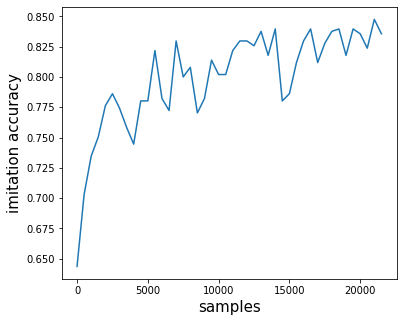

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(valids))
x = 500*x

fig, axes = plt.subplots(1,1, figsize=(6,5))
plt.plot(x,valids)
plt.xlabel('samples', fontsize=15)
# plt.ylim([0.5,1])

plt.ylabel('imitation accuracy', fontsize=15)

In [17]:
fig.savefig('imitation_acc.pdf')

In [4]:
!pip install matplotlib


     |████████████████████████████████| 11.5 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 29.5 MB/s eta 0:00:01


In [52]:
torch.save(policy.state_dict(), 'trained_models/trained_params.pkl')

In [59]:
policy_net = policy

In [73]:
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from gnn_dataset import BipartiteNodeData, GraphDataset
from gnn_policy import GNNPolicy, BipartiteGraphConvolution
from tqdm import tqdm
from pathlib import Path

class Episode(object):
    def __init__(self):
        self.reward_history = []
        self.reward_history = []
        self.loss_history = []
        self.gamma = 0.99
        
episode = Episode()


def get_graph_from_obs(sample_observation, sample_action_set):
       
        sample_action_id = sample_action_set[0] # doen't matter won't be used
        # We note on which variables we were allowed to branch, the scores as well as the choice 
        # taken by expert branching (relative to the candidates)
        candidates = torch.LongTensor(np.array(sample_action_set, dtype=np.int32))
        candidate_choice = torch.where(candidates == sample_action_id)[0][0]

        graph = BipartiteNodeData(sample_observation.antenna_features, sample_observation.edge_index, 
                                  sample_observation.edge_features, sample_observation.variable_features,
                                  candidates, candidate_choice)
        
        # We must tell pytorch geometric how many nodes there are, for indexing purposes
        graph.num_nodes = sample_observation.antenna_features.shape[0] + sample_observation.variable_features.shape[0]
        
        return graph

class Policy(nn.Module):
    def __init__(self, init_policy_net, temperature):
        super().__init__()
        self.policy_net = init_policy_net
        self.temperature = temperature
        self.sf = nn.Softmax()
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        
    def forward(self, state, action_set):
        logits = self.policy_net(state.antenna_features, state.edge_index, state.edge_features, state.variable_features)
        prob = Categorical(self.sf(logits/self.temperature))
        action_id = prob.sample()
        
        # Add log probability of our chosen action to our history    
        if self.policy_history.dim() != 0:
            self.policy_history = torch.cat([self.policy_history, prob.log_prob(action_id)])
        else:
            self.policy_history = (prob.log_prob(action_id))
        return action_id
    

def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []
    


In [74]:
# add policy network
MAX_ITER = 1000
punishment_for_incomplete_episode = -1000

# load and initialize policy
temperature = 2
policy = Policy(policy_net, temperature)
env = ACRBBenv()

def main(num_episodes):
    running_reward = -1
    avg_length = []
    for i in range(num_episodes):
        instance
        obs, action_set, reward, done, _ = env.reset()
        if done:
            policy.reward_episode.append(reward)
            update_policy()
            continue
        
        for it in range(MAX_ITER):
            state = get_graph_from_obs(obs, action_set)
            action_id = policy(state, state)
            # Step through environment using chosen action
            obs, action_set, reward, done, _ = env.step(action_set[action_id])
            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        if not done:
            policy.reward_episode.append(punishment_for_incomplete_episode)
        update_policy()
        avg_length.append(it)
        if episode % 5 == 0:
            print('Episode {}\tAverage length: {:.2f}'.format(episode, np.mean(avg_length)))
            avg_length = []


SyntaxError: invalid syntax (<ipython-input-74-55a82e910406>, line 8)

In [70]:
import numpy as np
np.mean([1,2,3])

2.0

In [72]:
num_episodes = 100
main(num_episodes)

NameError: name 'env' is not defined

In [10]:
import torch.nn as nn
from torch.distributions import Categorical

a = nn.Softmax()
b = a(torch.rand(5))
m = Categorical(b)
action = m.sample()

/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [2]:
import torch_geometric

In [12]:
m.log_prob(action)

tensor(-1.6983)